<a href="https://colab.research.google.com/github/gyana-ranjan-dash/World_proverty_analysis/blob/main/World_poverty_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import warnings
warnings.filterwarnings('ignore')


#Important libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## **1. Reading and understanding Dataset**

In [23]:
# importing data from CSV file

country_df = pd.read_csv("https://raw.githubusercontent.com/gyana-ranjan-dash/World_proverty_analysis/main/Country-data.csv")

In [24]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [25]:
country_df.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460


In [35]:
country_df.shape

(167, 10)

In [26]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [27]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [30]:
country_df.isnull().mean()*100

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64



--- We can see the dataset ``country_df`` do not contain any null values



--- All the columns have correct data type






## **Data  preparation and Cleaning**

In [31]:
country_df['exports'] = country_df['exports']*country_df['gdpp']/100
country_df['imports'] = country_df['imports']*country_df['gdpp']/100
country_df['health'] = country_df['health']*country_df['gdpp']/100

In [32]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## **EDA**

In [40]:
# dataframe with pnly required columns
df = country_df[["country","child_mort","income","gdpp"]]
df.head()

,country,child_mort,income,gdpp
0,Afghanistan,90.2,1610,553
1,Albania,16.6,9930,4090
2,Algeria,27.3,12900,4460
3,Angola,119.0,5900,3530
4,Antigua and Barbuda,10.3,19100,12200


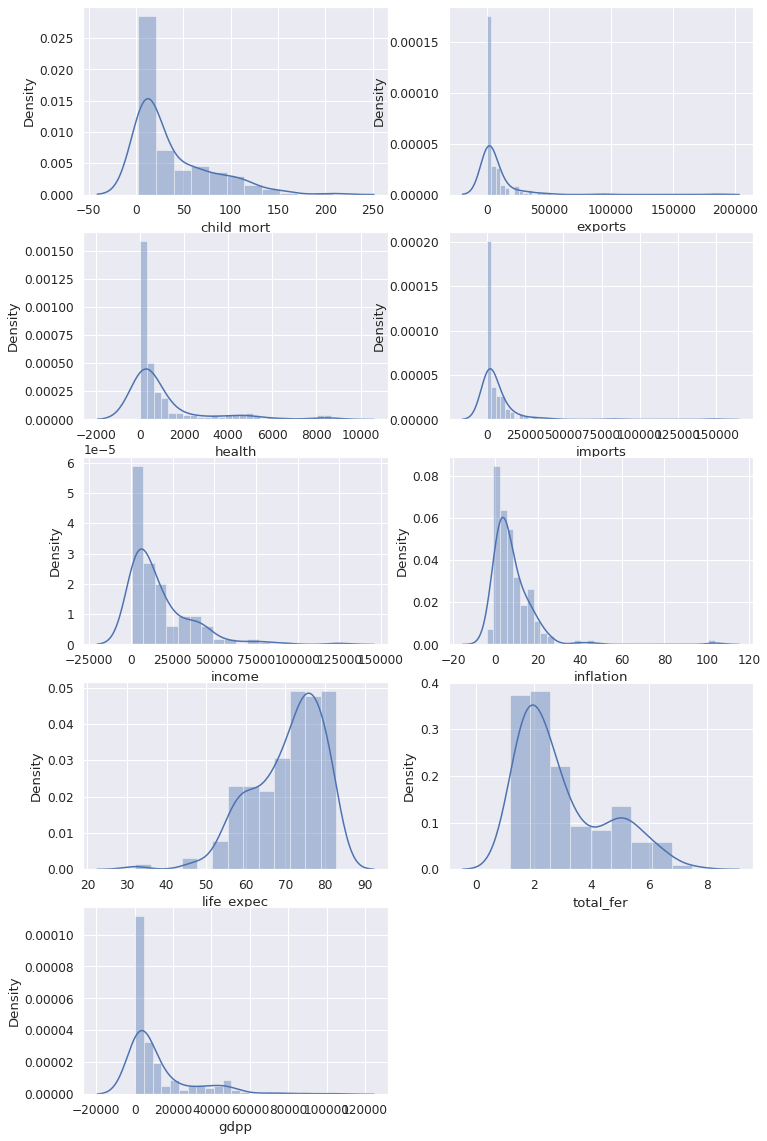

In [36]:
plt.figure(figsize=(12,20))
sns.set(font_scale = 1.1)
cols = country_df.columns[1:]
for i in enumerate(cols):
    plt.subplot(5,2,i[0]+1)
    sns.distplot(country_df[i[1]])
plt.show()

#### Inference :-
- all the variables are not noramlly distrubuted
- ``child_mort`` ``exports`` ``health`` ``imports`` ``income`` ``inflation`` ``total_fer`` and ``gdpp`` are positively skewed
- ``life_expec`` negatively skewed

<Figure size 720x360 with 0 Axes>

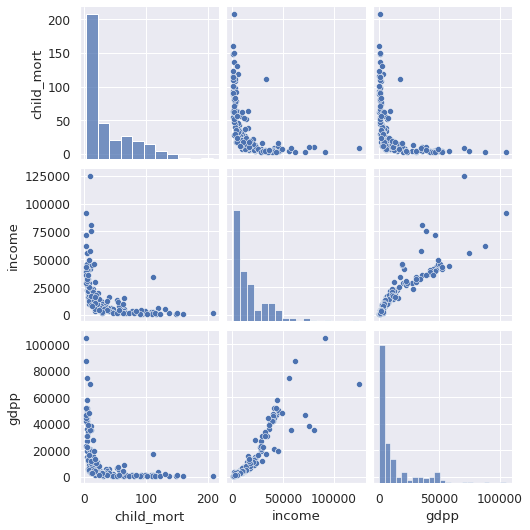

In [43]:
plt.figure(figsize=(10,5))
sns.pairplot(df)
plt.show()

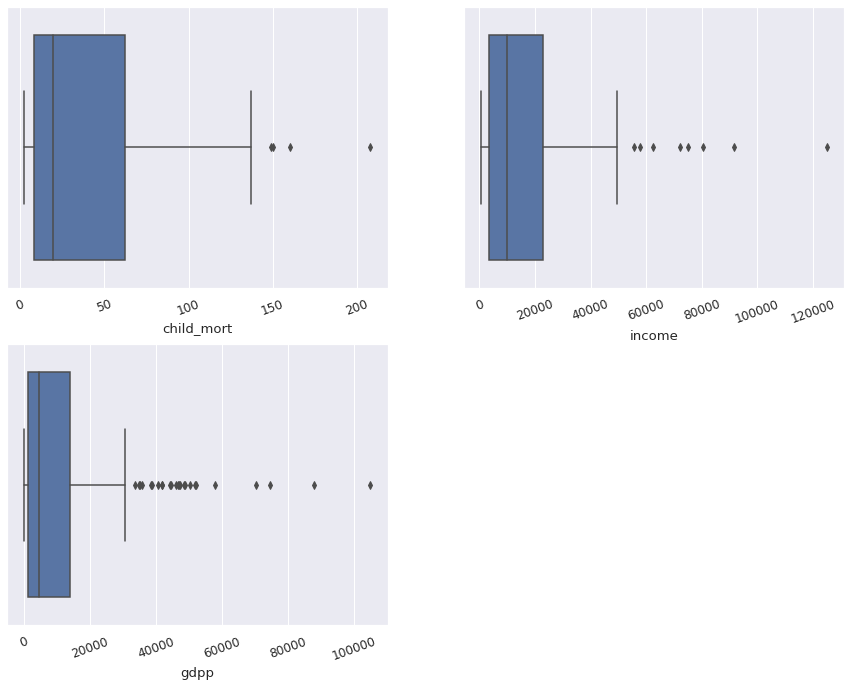

In [42]:
# checking for outliers
plt.figure(figsize=(15,30))
features = ['child_mort','income','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation = 20)

*There are outliers in every column*


1.   We cannot remove all the outliers from the columns as they are crucial for our analysis
2.   we can cap high value outlier with in ``income`` ``gdpp``  as we dont require them in our final result



In [44]:
q1 = df['gdpp'].quantile(0.95)
q2 = df['income'].quantile(0.95)
df['gdpp'][df['gdpp']>=q1] = q1
df['income'][df['income']>=q2] = q2

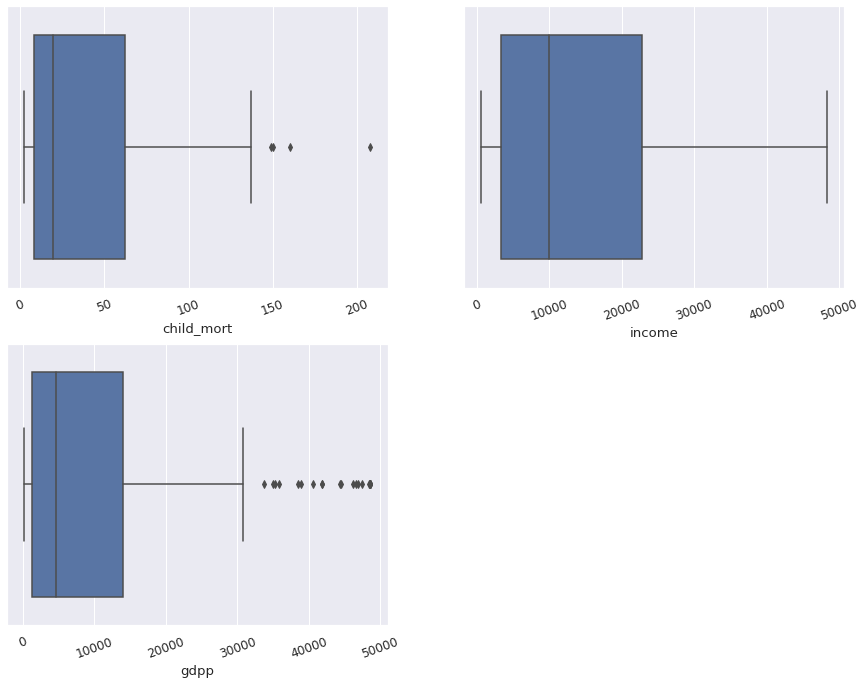

In [45]:
# checking for outliers
plt.figure(figsize=(15,30))
features = ['child_mort','income','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation = 20)